In [119]:
import psycopg2
import gensim
import faiss
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from adjustText import adjust_text
from faiss import write_index
plt.rcParams['figure.figsize'] = [10, 6]

# Traer los posts de la base de datos

In [2]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1", port="63333", database="stack_overflow")

In [31]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.post_type_id=1 
        and creation_date < '2022-01-01'
        and t.tag_name = 'python'
        limit 10000""")
        posts = cursor.fetchall()

In [33]:
posts[:3]

[(58745255,
  '"ImportError: DLL load failed: The specified module could not be found" when importing `tensorflow`',
  'Error imageI have TensorFlow 2.0 installed and have resolved my \nError – Could not load dynamic library ‘cudart64_90.dll’ by downloading and pasting the same file into: *\nC:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\bin.\nNow that this issue is clear, I got the subjected error while importing tensorflow from Jupyter notebook (GPU).\nI tried the following.\nAm I missing anything?\n'),
 (58745285,
  'ValueError: Tensor Conversion Error Tensorflow',
  'I create tfrecord files and put them in the right directory\nC:\\Users\\Admin\\Desktop\\models\\research\\object_detection\\data\nand then I run train.py then this error pops up\nTraceback (most recent call last):\nFile "legacy/train.py", line 184, in <module>\ntf.app.run()\nFile "C:\\Users\\Jayson\\Anaconda3\\lib\\site-packages\\tensorflow_core\\python\\platform\\app.py", line 40, in run\n_run(main=main

In [34]:
class MyCorpus():
    def __init__(self, posts) -> None:
        self.posts = posts
        self.id2post = dict()
        
    def __iter__(self):
        for p_id, title, body in self.posts:
            post_text = body
            if title is not None:
                post_text = title + "\n\n" + body
            tokens = gensim.utils.simple_preprocess(post_text)
            self.id2post[str(p_id)] = post_text
            # Use string due to int management in doc2vec
            # https://stackoverflow.com/questions/43051902/gensim-docvecs-most-similar-returns-ids-that-dont-exist
            yield gensim.models.doc2vec.TaggedDocument(tokens, [str(p_id)])
    
    def get_post_text(self, post_id):
        return self.id2post[post_id]

    def get_post_tokens(self, post_id):
        return gensim.utils.simple_preprocess(self.id2post[post_id])

# Entrenar el doc2vec

In [93]:
corpus = MyCorpus(posts)
model = gensim.models.doc2vec.Doc2Vec(corpus, vector_size=20, epochs=30, hs=1, min_count=5, workers=8)

In [94]:
model.save('model.doc')

In [95]:
posts[3]

(58745400,
 'Previous and next array should have two much common values pandas',
 'I have a dataframe like ,\nTest              Test1\n[1,1,1]          [1,2,2]\n[1,2,2]          [1,0,1]\n[1,0,1]          [1,1,0]\n[2,2,0]          [0,2,2]\n[1,2,0]          [1,0,2]\n\nI am trying to compare the two arrays where 2 numbers should match and third one should be o.So like   [1,0,1]   [1,1,0]  should be matched and return true as two numbers are matching and third one is 0 . same for [2,2,0]          [0,2,2]  but [1,2,0]          [1,0,2]  this should not match as it does not have the same numbers.will return false. So,Is there any way to do this ?\n')

In [96]:
model.infer_vector(corpus.get_post_tokens(str(posts[3][0])))

array([-1.3094778 , -0.64085823, -3.1758962 ,  2.0756257 , -0.2993245 ,
       -0.24134584, -0.28066522,  3.2605548 , -1.4479603 , -0.817428  ,
       -2.2401521 ,  0.10326257, -0.31739485, -3.1847248 ,  0.91961354,
        0.59197164,  1.6441972 , -2.3903942 , -2.6168945 ,  0.17421967],
      dtype=float32)

# Traer vecinos cercanos con doc2vec

In [97]:
post0_vector = model.infer_vector(corpus.get_post_tokens(str(posts[3][0])))
ids_sim = model.dv.most_similar([post0_vector], topn=3)
print(f"similarity: {ids_sim[0][1]}, for doc id: {ids_sim[0][0]}")
for p_id, sim in ids_sim[1:]:
    print(f"similarity: {sim}, for doc: {corpus.get_post_text(p_id)}")

similarity: 0.9696085453033447, for doc id: 58745400
similarity: 0.8367121815681458, for doc: Find the "n" largest elements in a Python 'list' with duplicate values

Suppose I have a list as shown:
test= [19, 2, 8, 12, 8]

I sorted it as:
print(sorted([(val, idx) for (idx, val) in enumerate(test)], reverse = True))

Output is:
[(19, 0), (12, 3), (8, 4), (8, 2), (2, 1)]

I want to extract the first 4 largest numbers. Slicing will not work as I have duplicates in list (8 at indices 2 and 4)
The output am expecting is:
(19, 0), (12, 3), (8, 4), (8, 2)
Is there any other way to get this done? 

similarity: 0.835109531879425, for doc: How to generate all possible combinations of columns in a pandas dataframe with many columns?

I have the following DataFrame:
   A  B  C
0  1  3  3
1  1  9  4
2  4  6  3

I would like to create every possible unique combination of these columns without repetition so that I would end up with a dataframe containing the following data: A, B, C, A+B, A+C, B+C, A+

# Traer vecinos cercanos con faiss

In [98]:
p_vectors_ids = [(model.infer_vector(p.words), p.tags[0]) for p in corpus]

In [99]:
vectors, vectors_ids = zip(*p_vectors_ids)
vectors = np.array(vectors)
vectors_ids = np.array(vectors_ids)

In [100]:
vectors_ids

array(['58745255', '58745285', '58745294', ..., '58889943', '58889930',
       '58890010'], dtype='<U8')

In [101]:
index = faiss.index_factory(20, "IDMap,Flat")
index.train(vectors)
index.add_with_ids(vectors, vectors_ids)

In [102]:
distances, neighbors = index.search(post0_vector.reshape(1,-1), 3)

for p_id, dist in zip(neighbors[0], distances[0]):
    print(f"distance: {dist}, for doc: {corpus.get_post_text(str(p_id))}")

distance: 0.5705269575119019, for doc: Previous and next array should have two much common values pandas

I have a dataframe like ,
Test              Test1
[1,1,1]          [1,2,2]
[1,2,2]          [1,0,1]
[1,0,1]          [1,1,0]
[2,2,0]          [0,2,2]
[1,2,0]          [1,0,2]

I am trying to compare the two arrays where 2 numbers should match and third one should be o.So like   [1,0,1]   [1,1,0]  should be matched and return true as two numbers are matching and third one is 0 . same for [2,2,0]          [0,2,2]  but [1,2,0]          [1,0,2]  this should not match as it does not have the same numbers.will return false. So,Is there any way to do this ?

distance: 17.266490936279297, for doc: Find the "n" largest elements in a Python 'list' with duplicate values

Suppose I have a list as shown:
test= [19, 2, 8, 12, 8]

I sorted it as:
print(sorted([(val, idx) for (idx, val) in enumerate(test)], reverse = True))

Output is:
[(19, 0), (12, 3), (8, 4), (8, 2), (2, 1)]

I want to extract 

In [118]:
write_index(index, "doc2vec.index")

# Posts TSNE

In [131]:
X_embedded = TSNE(n_components=2, init='random', perplexity=80).fit_transform(vectors)

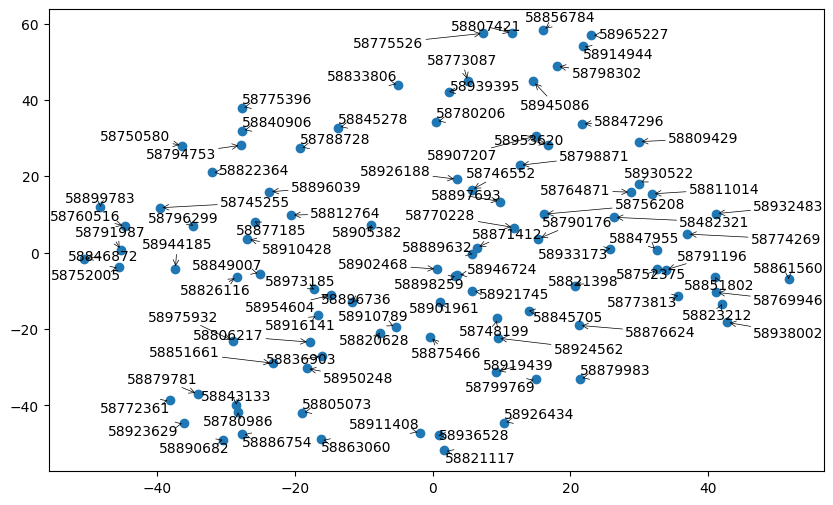

In [107]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[::100,0], X_embedded[::100,1])

texts = []
for i, p_id in enumerate(vectors_ids[::100]):
    texts.append(ax.text(X_embedded[i*100,0], X_embedded[i*100,1], p_id))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5));

In [114]:
print(corpus.get_post_text("58752375"))

Databricks: how to convert the values of the rows to array type

suppose I have the following data frame
col1
a
b
c
I would like to convert the values to a arrayType variable 
['a','b','c']
any idea ?



In [115]:
print(corpus.get_post_text("58791196"))

Long to wide DataFrame transformation

I'm trying to transform a data frame in the form:
Record  Value1 Value2 Value3
   0       1      2      3
   0       4      5      6
   0       7      8      9
   1       1      2      3
   1       4      5      6
   1       7      8      9
   2       1      2      3
   2       4      5      6
   2       7      8      9

To a wide format where row contains all related values like this:
Record  Value1_1 Value2_1 Value3_1 Value1_2 Value2_2 Value3_2 Value1_3 Value2_3 Value3_3
   0        1      2         3         4        5       6        7        8        9
   1        1      2         3         4        5       6        7        8        9
   2        1      2         3         4        5       6        7        8        9

I've been trying to use pivot, pivot_table and reindex, methods but I either get cryptic errors on "column value is not 1-dimensional" or other undescriptive errors.
Any clues on how to do that? Pivoting and multi-indexes are v

In [116]:
print(corpus.get_post_text("58752005"))

zsh: permission denied while trying to use 'radb' on Mac OS

I have python 3 installed and the version is 3.7.
Then I follow the RA documentation to install the radb from my terminal.
I put comment: pip3 install radb and it installed successfully.
Then I download the beers.ra example from the page.
Then I tried the comment radb -i beers.ra beers.db and it return zsh: command not found: radb.
Then I tried comment "pip3 show -f radb" and found out the path way so I try again by typing: 
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/radb radb -i beers.ra beers.db 
and it return
zsh: permission denied: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/radb

Then I search Google and try to gain the permission by use: 
sudo chown -R $USER /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/radb radb -i beers.ra beers.db
but it return
chown: radb: No such file or directory
chown: -i: No such file or director

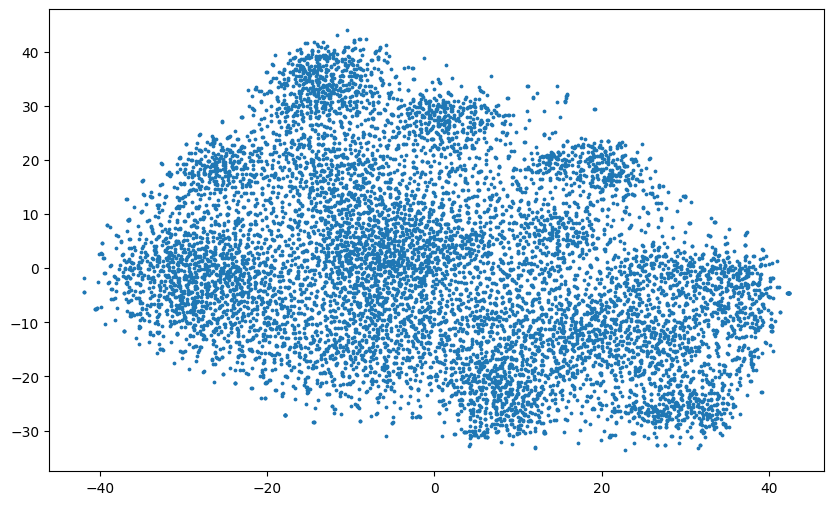

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,1], s=3)

# TSNE por pais

In [121]:
posts[50][1], posts[50][2]

('How do I send key presses and mouse movements to an application running in the background? (In Python)',
 "Ok, so what I want to do is allow my program to send mouse movements and keypresses (both mouse and keyboard) to a particular task without having to be tabbed into the task so I can do other things on my computer with the mouse and keyboard while the task runs. Is it possible to do this relatively simply with existing python modules?\nexample of what I want to do:\n\ntask='application name'\ntask.leftclick\ntask.moveX(int)\ntask.moveY(int)\ntask.keypress(r)\n\nAll while being able to use my mouse and keyboard normally on a different application.\nThanks for the help in advance!\n(Python3.6)\n")

In [122]:
post0_vector = model.infer_vector(corpus.get_post_tokens(str(posts[50][0])))

In [124]:
distances, neighbors = index.search(post0_vector.reshape(1,-1), 5)

for p_id, dist in zip(neighbors[0], distances[0]):
    print(f"distance: {dist}, for doc: {corpus.get_post_text(str(p_id))}")

distance: 0.26809394359588623, for doc: How do I send key presses and mouse movements to an application running in the background? (In Python)

Ok, so what I want to do is allow my program to send mouse movements and keypresses (both mouse and keyboard) to a particular task without having to be tabbed into the task so I can do other things on my computer with the mouse and keyboard while the task runs. Is it possible to do this relatively simply with existing python modules?
example of what I want to do:

task='application name'
task.leftclick
task.moveX(int)
task.moveY(int)
task.keypress(r)

All while being able to use my mouse and keyboard normally on a different application.
Thanks for the help in advance!
(Python3.6)

distance: 35.53038787841797, for doc: Python Tkinter app freezes on bound ctrl-a IFF ctrl-a was enacted in command shell from which the script was launched

I have an application in which I want to use Ctrl-A to 'select all' within my canvas.  I have done :
 canvas.bi